# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band9.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.324570 -0.360819  0.230272 -0.226338  0.021130  0.324849   
      201547 -0.273344 -0.235496 -0.286224  0.626353  0.094836 -0.589532   
      201548  0.140561 -0.079555  0.054116 -0.223006 -0.027519 -0.209988   
      201549  0.077679 -0.070066 -0.122719  0.036092 -0.278688  0.066342   
      201550  0.558640  0.558777 -0.165784  0.611903 -0.249079  0.079143   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.332807 -0.071086 -0.074837  0.196332  ...  0.148197  0.379929   
      201547 -0.179341  0.564423  0.270267 -0.035233  ... -0.077868 -0.340677   
      201548 -0.334761  0.140228 -0.342089 -0.192351  ... -0.122560 -0.323692   
      201549  0.622364 -0.108879 -0.210161  0.289703  ...  0.077183 -0.195554   
      201550  0.291969  0.365494 -0.183783  0.131291  ... -0.237401 -0.554573   

                  1017      1018      1019      1020      1021      1022  \
41001 201546 -0.072068 -0.027047 -0.873004  0.440666  0.236128 -0.247892   
      201547  0.154335 -0.012081  0.328511  0.693349 -0.077022 -0.102800   
      201548 -0.245404  0.057127  0.179502 -0.042829 -0.353594 -0.188833   
      201549 -0.112804  0.154031  0.278953  0.301413  0.562627  0.018445   
      201550  0.189724 -0.350103  0.440411  0.108747  0.237476 -0.625539   

                  1023    Labels  
41001 201546  0.225572 -0.861740  
      201547 -0.085177 -0.854589  
      201548  0.021431 -0.856973  
      201549 -0.336531 -0.856973  
      201550  0.092921 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.131088 -0.004110 -0.074716  0.265878 -0.103730 -0.155703   
      201821  0.424696  0.358304 -0.166390  0.307311 -0.103258 -0.079666   
      201822  0.960665 -0.176998 -0.321990 -0.055522  0.034895  0.036288   
      201823  0.094877 -0.389793 -0.219061  0.054405 -0.032591 -0.001621   
      201824 -0.159156  0.463764 -0.107125 -0.319070 -0.209726  0.150824   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.473650  0.115341  0.216997 -0.061094  ... -0.295335 -0.376156   
      201821  0.010067  0.379908  0.475020  0.483503  ... -0.585594  0.179959   
      201822 -0.249606  0.106964 -0.282088  0.002425  ...  0.200366 -0.403955   
      201823 -0.116576 -0.070271 -0.319443 -0.212817  ...  0.819520 -0.101873   
      201824  0.286498 -0.204171 -0.214230 -0.010204  ... -0.202535 -0.270099   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.022754 -0.148749 -0.685104  0.205094 -0.299095 -0.183579   
      201821 -0.485962  0.140479  0.033794  0.221552 -0.069519 -0.281848   
      201822 -0.270582  0.114978  0.039832 -0.325681  0.586999  0.062509   
      201823 -0.460470  0.095229 -0.600001  0.110074  0.007769 -0.360643   
      201824  0.016564  0.163647 -0.108276 -0.431607  0.011276 -0.072012   

                  1023    Labels  
41001 201820  0.203384 -0.949940  
      201821  0.402031 -0.961859  
      201822  0.042158 -0.940405  
      201823 -0.186474 -0.961859  
      201824 -0.644477 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

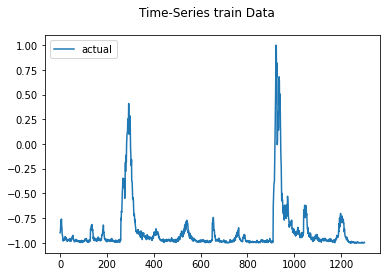

2023-03-14 15:36:24.664071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 15:36:24.664127: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 15:36:24.664170: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 15:36:24.664478: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:36:24.776203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 53.706
Test RMSE: 64.357
Test sMAPE: 106.348
Test R Squared: -3.286
{'mae': 53.70603493099863, 'rmse': 64.35738885068191, 'smape': 106.34750509612734, 'r2': -3.285868406210535}


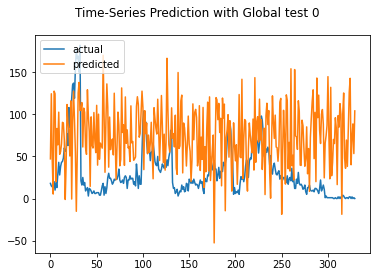

Test MAE: 59.858
Test RMSE: 68.298
Test sMAPE: 110.469
Test R Squared: -3.827
{'mae': 59.857522363373725, 'rmse': 68.29772510405837, 'smape': 110.46926932019075, 'r2': -3.8267463639843102}


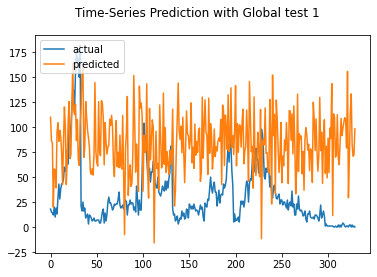

Test MAE: 52.146
Test RMSE: 60.884
Test sMAPE: 105.301
Test R Squared: -2.836
{'mae': 52.1457587372173, 'rmse': 60.88353557335476, 'smape': 105.3006818522259, 'r2': -2.8356743697986144}


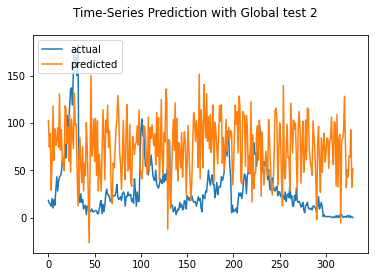

Test MAE: 62.423
Test RMSE: 72.274
Test sMAPE: 111.654
Test R Squared: -4.405
{'mae': 62.423070041157985, 'rmse': 72.27358775823834, 'smape': 111.65404965117138, 'r2': -4.405068846389218}


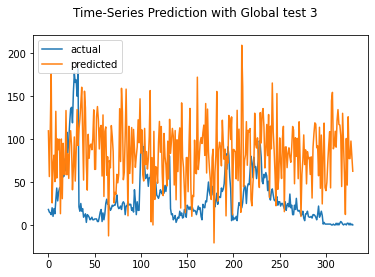

Test MAE: 43.809
Test RMSE: 52.190
Test sMAPE: 98.514
Test R Squared: -1.819
{'mae': 43.80939404386463, 'rmse': 52.19041944494914, 'smape': 98.51436980903509, 'r2': -1.8185359340552125}


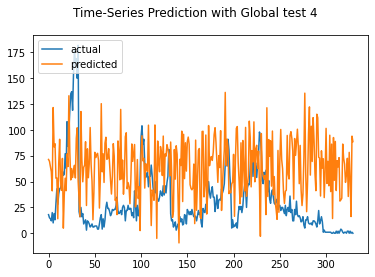

Test MAE: 53.994
Test RMSE: 63.675
Test sMAPE: 106.537
Test R Squared: -3.195
{'mae': 53.99353654565233, 'rmse': 63.675263371592436, 'smape': 106.53740231093393, 'r2': -3.1954978374547442}


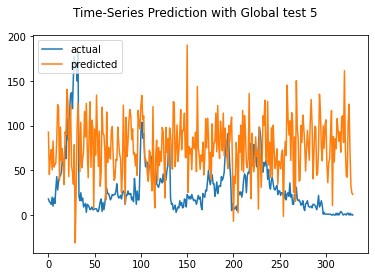

Test MAE: 43.360
Test RMSE: 52.983
Test sMAPE: 100.770
Test R Squared: -1.905
{'mae': 43.36015938014695, 'rmse': 52.98256171301863, 'smape': 100.77010504268057, 'r2': -1.9047442921047044}


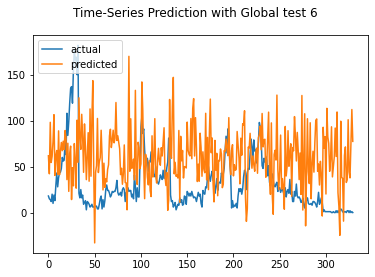

Test MAE: 40.804
Test RMSE: 49.996
Test sMAPE: 104.098
Test R Squared: -1.587
{'mae': 40.8042818634799, 'rmse': 49.996298350662244, 'smape': 104.09772553903632, 'r2': -1.5865310944167224}


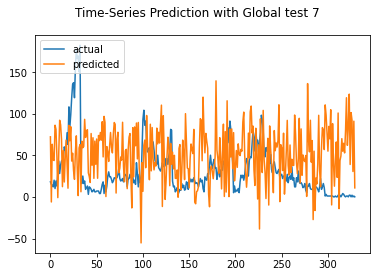

Test MAE: 53.705
Test RMSE: 63.200
Test sMAPE: 106.560
Test R Squared: -3.133
{'mae': 53.7048741571831, 'rmse': 63.20021835958887, 'smape': 106.5599690043662, 'r2': -3.1331308928485226}


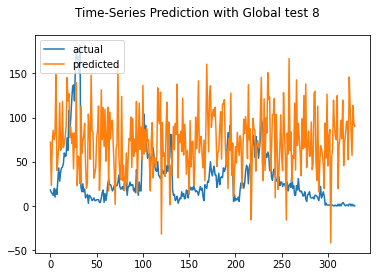

Test MAE: 35.421
Test RMSE: 44.549
Test sMAPE: 100.465
Test R Squared: -1.054
{'mae': 35.42138856938391, 'rmse': 44.549240673738424, 'smape': 100.46548075794584, 'r2': -1.0536319564143626}


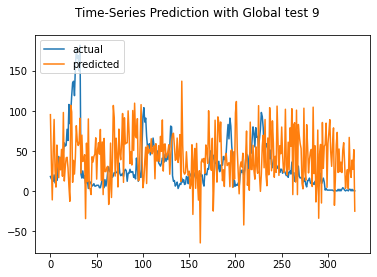

Test MAE: 62.343
Test RMSE: 71.871
Test sMAPE: 113.509
Test R Squared: -4.345
{'mae': 62.34330722346451, 'rmse': 71.87147376044875, 'smape': 113.50943012636029, 'r2': -4.345090987117368}


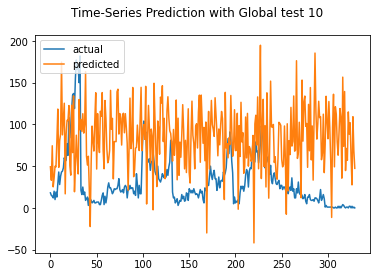

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 46.332
Test RMSE: 56.926
Test sMAPE: 117.374
Test R Squared: -2.353
{'mae': 46.331659360184815, 'rmse': 56.92626689018855, 'smape': 117.37357559608014, 'r2': -2.353261408641098}


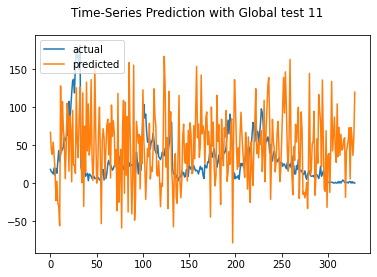

Test MAE: 35.961
Test RMSE: 45.421
Test sMAPE: 106.601
Test R Squared: -1.135
{'mae': 35.96135789020495, 'rmse': 45.42107642474841, 'smape': 106.60070113952567, 'r2': -1.1347982896565854}


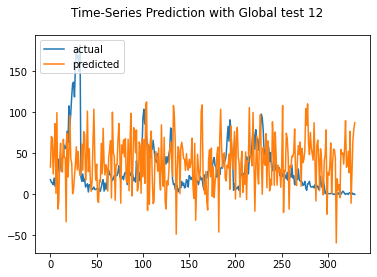

Test MAE: 39.032
Test RMSE: 48.510
Test sMAPE: 98.014
Test R Squared: -1.435
{'mae': 39.03169437375936, 'rmse': 48.51044056442043, 'smape': 98.01395009089985, 'r2': -1.4350755459671904}


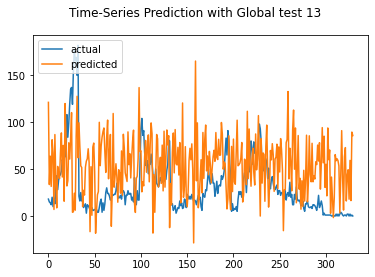

Test MAE: 57.759
Test RMSE: 67.179
Test sMAPE: 108.606
Test R Squared: -3.670
{'mae': 57.758738832401505, 'rmse': 67.17907654208284, 'smape': 108.60639466197163, 'r2': -3.669926668730125}


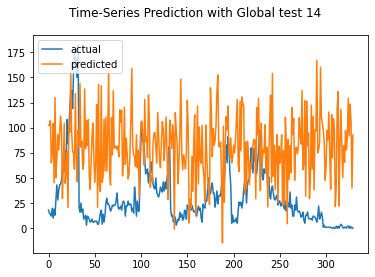

Test MAE: 51.621
Test RMSE: 60.214
Test sMAPE: 106.302
Test R Squared: -2.752
{'mae': 51.62066371224143, 'rmse': 60.214085600735, 'smape': 106.30199938373622, 'r2': -2.7517871614714977}


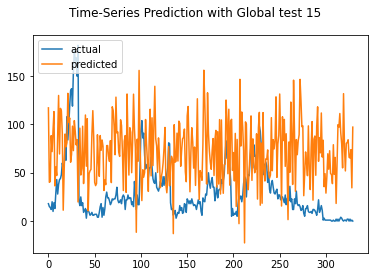

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 51.015
Test RMSE: 63.593
Test sMAPE: 112.074
Test R Squared: -3.185
{'mae': 51.014855509454556, 'rmse': 63.59269404113179, 'smape': 112.07417282961306, 'r2': -3.1846240750669343}


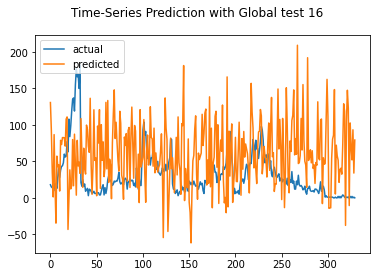

Test MAE: 72.584
Test RMSE: 82.474
Test sMAPE: 116.320
Test R Squared: -6.038
{'mae': 72.58352453780897, 'rmse': 82.47386202552168, 'smape': 116.319602200309, 'r2': -6.03841168096464}


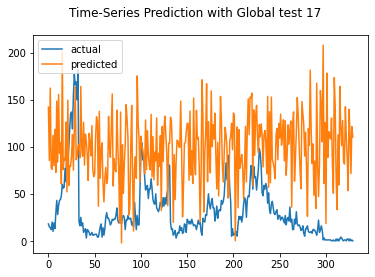

Test MAE: 48.569
Test RMSE: 56.168
Test sMAPE: 103.533
Test R Squared: -2.265
{'mae': 48.56920429432031, 'rmse': 56.168090006516735, 'smape': 103.53303389447119, 'r2': -2.2645348829556036}


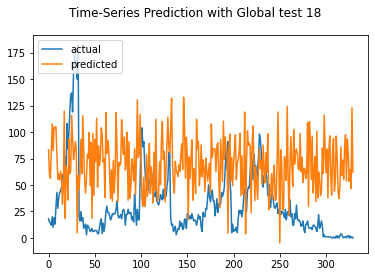

Test MAE: 37.177
Test RMSE: 46.476
Test sMAPE: 100.732
Test R Squared: -1.235
{'mae': 37.17679422208757, 'rmse': 46.47634526378021, 'smape': 100.7315919395027, 'r2': -1.2351462252856762}


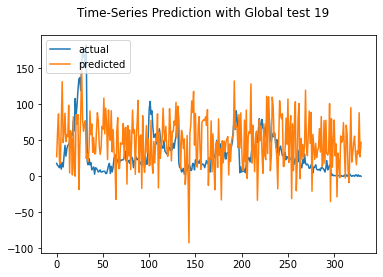

Test MAE: 73.463
Test RMSE: 83.512
Test sMAPE: 118.057
Test R Squared: -6.217
{'mae': 73.46332852695927, 'rmse': 83.51210230709266, 'smape': 118.05686996055027, 'r2': -6.216736274255205}


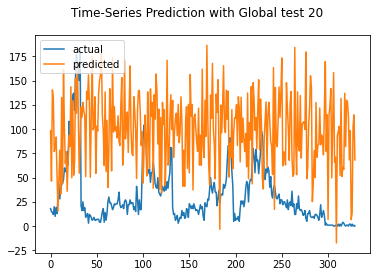

Test MAE: 40.415
Test RMSE: 51.306
Test sMAPE: 104.894
Test R Squared: -1.724
{'mae': 40.415479173624156, 'rmse': 51.30603855018535, 'smape': 104.89353295556771, 'r2': -1.7238235342932509}


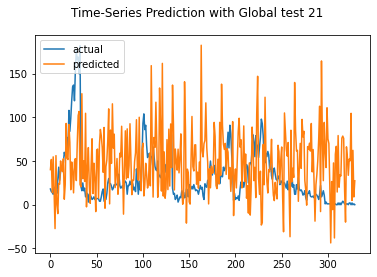

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 46.479
Test RMSE: 58.037
Test sMAPE: 105.278
Test R Squared: -2.485
{'mae': 46.47867829619032, 'rmse': 58.03676356428358, 'smape': 105.27804044468253, 'r2': -2.485365864714765}


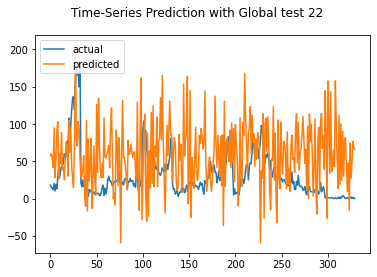

Test MAE: 46.250
Test RMSE: 55.552
Test sMAPE: 102.591
Test R Squared: -2.193
{'mae': 46.250400604623735, 'rmse': 55.551969067798936, 'smape': 102.59120545693713, 'r2': -2.193308789243571}


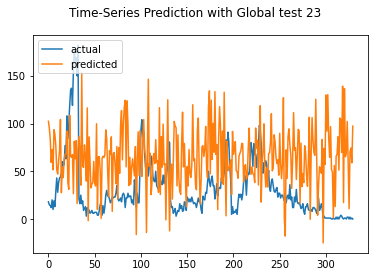

Test MAE: 41.586
Test RMSE: 50.847
Test sMAPE: 98.201
Test R Squared: -1.675
{'mae': 41.58628208872044, 'rmse': 50.84700420445898, 'smape': 98.20055807680336, 'r2': -1.675301557003833}


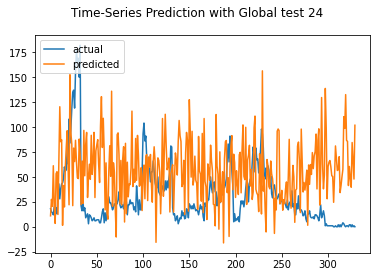

Test MAE: 41.543
Test RMSE: 51.294
Test sMAPE: 97.556
Test R Squared: -1.723
{'mae': 41.5428477229494, 'rmse': 51.29391892029216, 'smape': 97.55618272047589, 'r2': -1.7225368306221367}


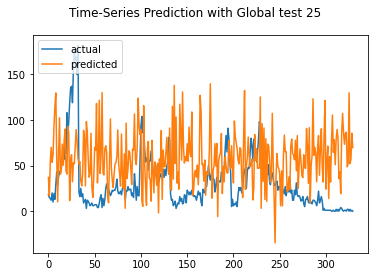

Test MAE: 58.815
Test RMSE: 66.756
Test sMAPE: 110.364
Test R Squared: -3.611
{'mae': 58.81512230201201, 'rmse': 66.75555170998162, 'smape': 110.36358082724958, 'r2': -3.611229959018897}


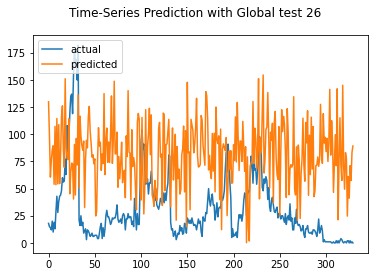

Test MAE: 36.337
Test RMSE: 46.394
Test sMAPE: 104.517
Test R Squared: -1.227
{'mae': 36.33708364530043, 'rmse': 46.393778843364395, 'smape': 104.51696575077729, 'r2': -1.2272116902127812}


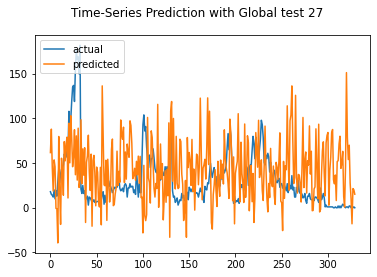

Test MAE: 55.237
Test RMSE: 64.036
Test sMAPE: 107.860
Test R Squared: -3.243
{'mae': 55.23654228033441, 'rmse': 64.03589394908897, 'smape': 107.86042851435244, 'r2': -3.2431555715154783}


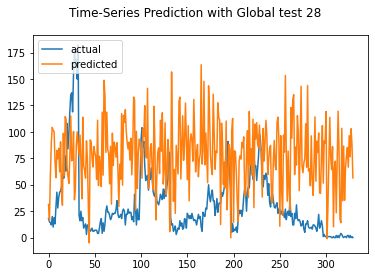

Test MAE: 38.750
Test RMSE: 48.114
Test sMAPE: 101.736
Test R Squared: -1.395
{'mae': 38.74976511055773, 'rmse': 48.11398748089356, 'smape': 101.73594839468777, 'r2': -1.3954367241124204}


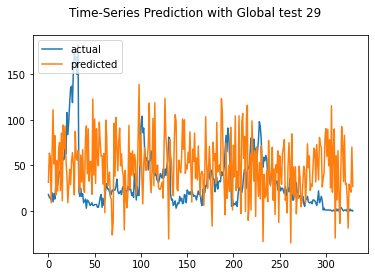

Test MAE: 43.445
Test RMSE: 52.773
Test sMAPE: 102.376
Test R Squared: -1.882
{'mae': 43.44484660444838, 'rmse': 52.77259156531035, 'smape': 102.37584650610202, 'r2': -1.8817668810068833}


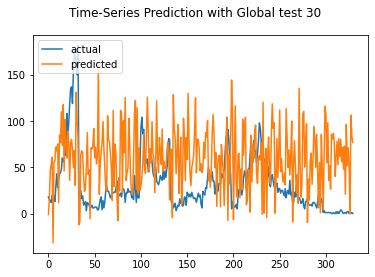

Test MAE: 41.769
Test RMSE: 51.856
Test sMAPE: 96.677
Test R Squared: -1.783
{'mae': 41.769377039418075, 'rmse': 51.856446540431186, 'smape': 96.67710492313248, 'r2': -1.7825790343641583}


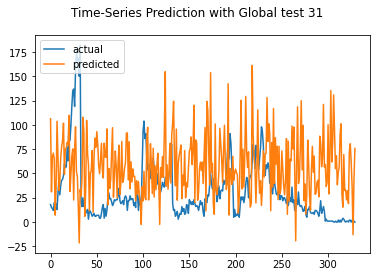

Test MAE: 40.367
Test RMSE: 48.820
Test sMAPE: 101.671
Test R Squared: -1.466
{'mae': 40.367392626675695, 'rmse': 48.82025401735072, 'smape': 101.67074240215699, 'r2': -1.4662782402771701}


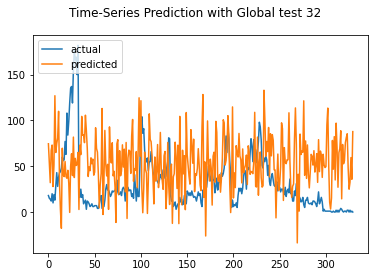

Test MAE: 60.769
Test RMSE: 68.537
Test sMAPE: 110.370
Test R Squared: -3.861
{'mae': 60.76910896879254, 'rmse': 68.53656516403939, 'smape': 110.37009053484331, 'r2': -3.8605640678795874}


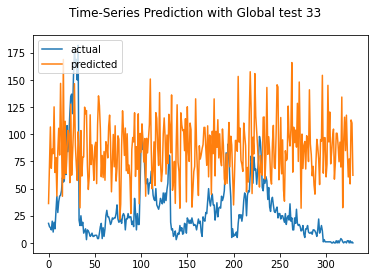

Test MAE: 39.847
Test RMSE: 49.172
Test sMAPE: 95.681
Test R Squared: -1.502
{'mae': 39.84679549950542, 'rmse': 49.17231632963362, 'smape': 95.68084040068285, 'r2': -1.5019771282568737}


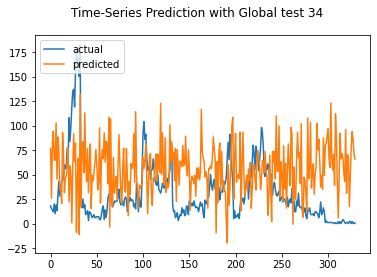

Test MAE: 44.657
Test RMSE: 53.924
Test sMAPE: 100.806
Test R Squared: -2.009
{'mae': 44.657462946935134, 'rmse': 53.923938407497545, 'smape': 100.80622545615971, 'r2': -2.008882369623986}


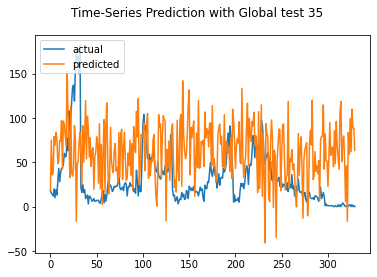

Test MAE: 50.201
Test RMSE: 59.147
Test sMAPE: 106.562
Test R Squared: -2.620
{'mae': 50.201342280976704, 'rmse': 59.14686237851713, 'smape': 106.56185422482004, 'r2': -2.619973771991977}


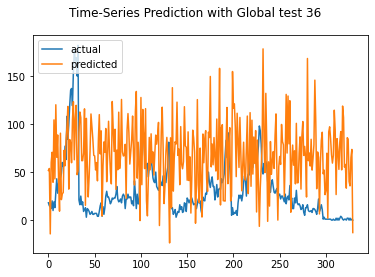

Test MAE: 69.324
Test RMSE: 77.304
Test sMAPE: 115.989
Test R Squared: -5.184
{'mae': 69.32353293100992, 'rmse': 77.30407138155363, 'smape': 115.98948942416969, 'r2': -5.183676150438203}


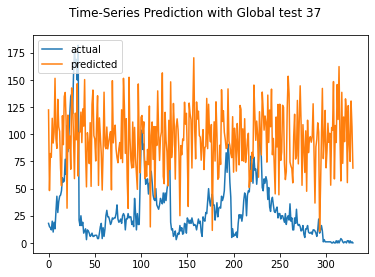

Test MAE: 38.964
Test RMSE: 48.426
Test sMAPE: 98.726
Test R Squared: -1.427
{'mae': 38.96352650992798, 'rmse': 48.42635064942054, 'smape': 98.72607389858265, 'r2': -1.4266407505223344}


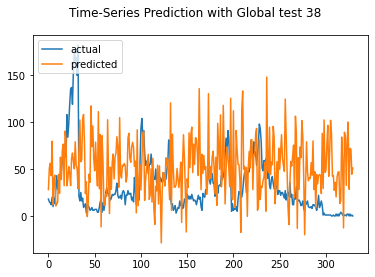

Test MAE: 42.323
Test RMSE: 51.573
Test sMAPE: 105.157
Test R Squared: -1.752
{'mae': 42.32290702028708, 'rmse': 51.573247359739455, 'smape': 105.15719383706919, 'r2': -1.7522695021528123}


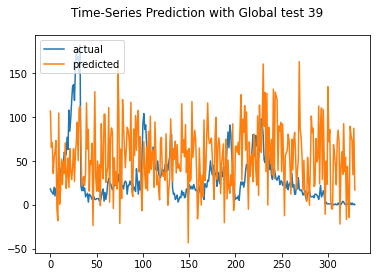

Test MAE: 40.469
Test RMSE: 50.730
Test sMAPE: 101.164
Test R Squared: -1.663
{'mae': 40.46896912636179, 'rmse': 50.73031622457369, 'smape': 101.16412406019036, 'r2': -1.6630366326166728}


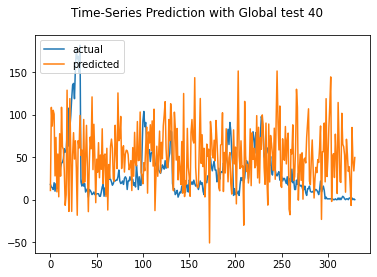

Test MAE: 39.784
Test RMSE: 50.059
Test sMAPE: 102.890
Test R Squared: -1.593
{'mae': 39.783960158174686, 'rmse': 50.05859763139194, 'smape': 102.88965843709425, 'r2': -1.592981148839693}


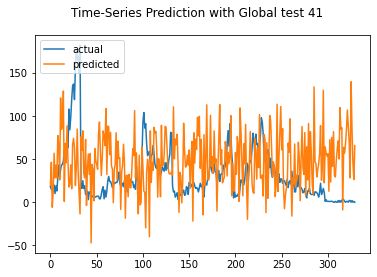

Test MAE: 59.569
Test RMSE: 69.161
Test sMAPE: 111.989
Test R Squared: -3.950
{'mae': 59.56916535912138, 'rmse': 69.16078752614352, 'smape': 111.98926532903707, 'r2': -3.949506072830915}


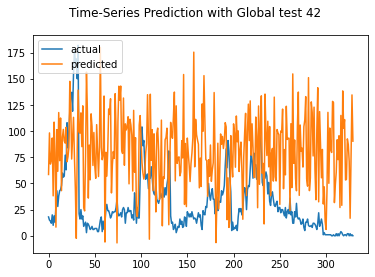

Test MAE: 50.578
Test RMSE: 60.440
Test sMAPE: 106.969
Test R Squared: -2.780
{'mae': 50.57798377817328, 'rmse': 60.440156372898244, 'smape': 106.96932991967346, 'r2': -2.780011840695241}


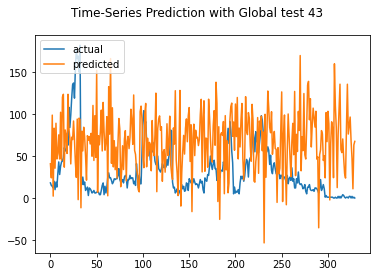

Test MAE: 43.198
Test RMSE: 53.502
Test sMAPE: 104.096
Test R Squared: -1.962
{'mae': 43.1983032554388, 'rmse': 53.50244895547255, 'smape': 104.0961942657162, 'r2': -1.9620291237115892}


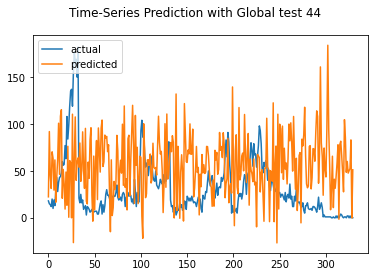

Test MAE: 46.553
Test RMSE: 56.363
Test sMAPE: 103.995
Test R Squared: -2.287
{'mae': 46.55275783213702, 'rmse': 56.363010667746565, 'smape': 103.99504153619486, 'r2': -2.287232091310406}


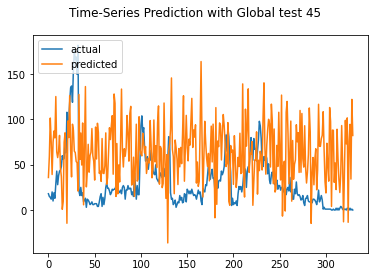

Test MAE: 47.953
Test RMSE: 56.734
Test sMAPE: 101.435
Test R Squared: -2.331
{'mae': 47.95258507006096, 'rmse': 56.73432895971032, 'smape': 101.43509193176503, 'r2': -2.3306871894349186}


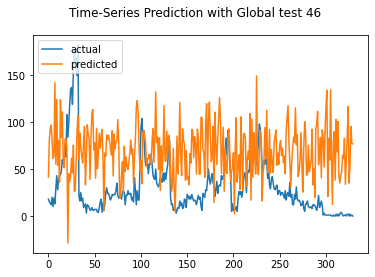

Test MAE: 61.332
Test RMSE: 69.290
Test sMAPE: 111.512
Test R Squared: -3.968
{'mae': 61.331921475583854, 'rmse': 69.28961152028273, 'smape': 111.51204130280678, 'r2': -3.967961877013871}


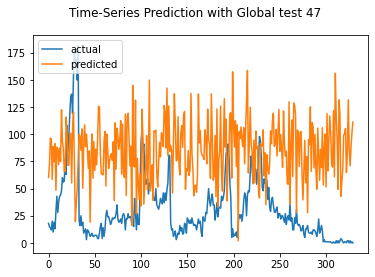

Test MAE: 53.710
Test RMSE: 62.103
Test sMAPE: 107.204
Test R Squared: -2.991
{'mae': 53.710487467592415, 'rmse': 62.10312022842533, 'smape': 107.203753530987, 'r2': -2.9908815989066744}


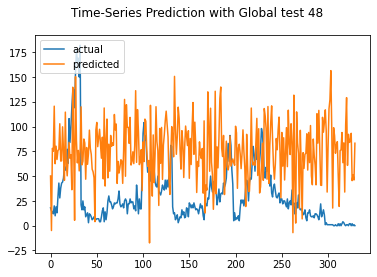

Test MAE: 44.299
Test RMSE: 53.813
Test sMAPE: 102.801
Test R Squared: -1.997
{'mae': 44.299365975278796, 'rmse': 53.81329521293304, 'smape': 102.80084806216166, 'r2': -1.9965475578084488}


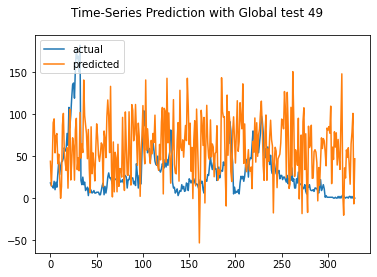

Test MAE: 46.025
Test RMSE: 53.775
Test sMAPE: 101.466
Test R Squared: -1.992
{'mae': 46.024703642816256, 'rmse': 53.774661783121694, 'smape': 101.46631572065935, 'r2': -1.9922465629026291}


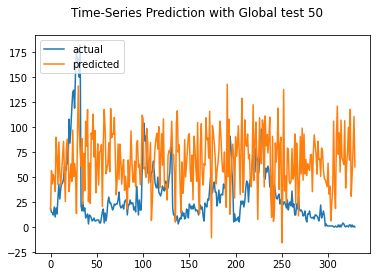

Test MAE: 40.111
Test RMSE: 49.217
Test sMAPE: 101.446
Test R Squared: -1.507
{'mae': 40.111344465703674, 'rmse': 49.21723058669718, 'smape': 101.44613228771215, 'r2': -1.5065498542948927}


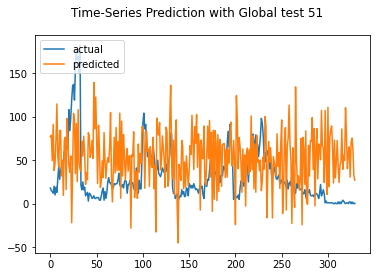

Test MAE: 43.400
Test RMSE: 52.127
Test sMAPE: 97.624
Test R Squared: -1.812
{'mae': 43.40025653550119, 'rmse': 52.12663971942056, 'smape': 97.62375135733903, 'r2': -1.8116513139174608}


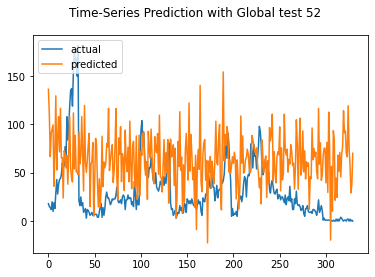

Test MAE: 42.885
Test RMSE: 51.475
Test sMAPE: 107.352
Test R Squared: -1.742
{'mae': 42.88488946665417, 'rmse': 51.47540177530467, 'smape': 107.35207309156208, 'r2': -1.7418361098782027}


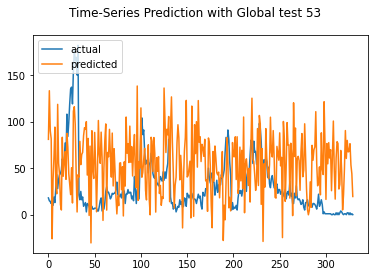

Test MAE: 42.966
Test RMSE: 51.303
Test sMAPE: 99.101
Test R Squared: -1.723
{'mae': 42.966428779833244, 'rmse': 51.30256588853087, 'smape': 99.10113443214125, 'r2': -1.7234548214596805}


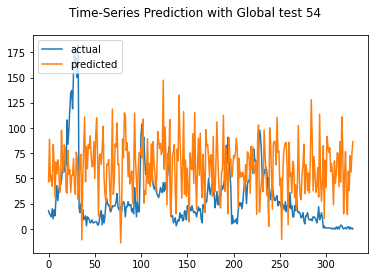

Test MAE: 38.887
Test RMSE: 48.188
Test sMAPE: 103.389
Test R Squared: -1.403
{'mae': 38.8873253789815, 'rmse': 48.188448339957596, 'smape': 103.38899662525779, 'r2': -1.4028567823880502}


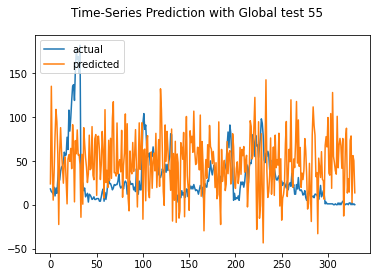

Test MAE: 41.463
Test RMSE: 49.555
Test sMAPE: 103.549
Test R Squared: -1.541
{'mae': 41.4634333514806, 'rmse': 49.55513033001218, 'smape': 103.54949926161683, 'r2': -1.5410853185223616}


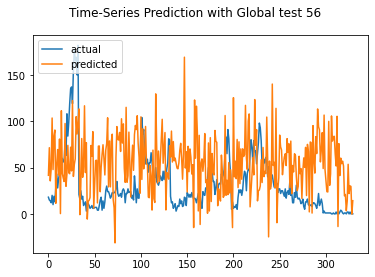

Test MAE: 50.781
Test RMSE: 61.062
Test sMAPE: 105.811
Test R Squared: -2.858
{'mae': 50.78072186365272, 'rmse': 61.061947871674526, 'smape': 105.81098429107479, 'r2': -2.8581873251116034}


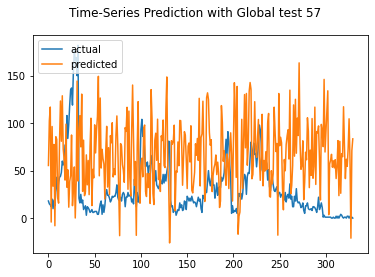

Test MAE: 47.449
Test RMSE: 56.304
Test sMAPE: 103.287
Test R Squared: -2.280
{'mae': 47.44938131588878, 'rmse': 56.30433047719333, 'smape': 103.28693472705012, 'r2': -2.280390902722581}


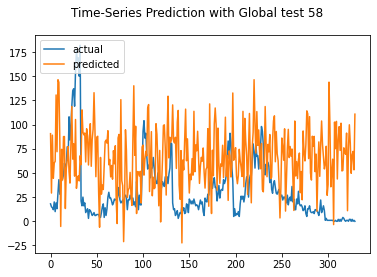

Test MAE: 57.934
Test RMSE: 66.553
Test sMAPE: 110.325
Test R Squared: -3.583
{'mae': 57.934210841583486, 'rmse': 66.5533644285066, 'smape': 110.325327970307, 'r2': -3.583339540449341}


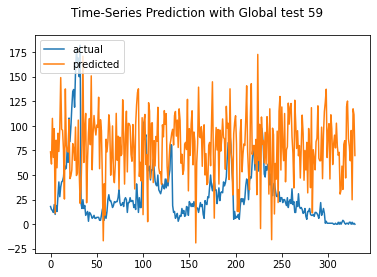

Test MAE: 47.956
Test RMSE: 57.560
Test sMAPE: 103.553
Test R Squared: -2.428
{'mae': 47.95611044204596, 'rmse': 57.55951446648645, 'smape': 103.55338398988502, 'r2': -2.4282796865475684}


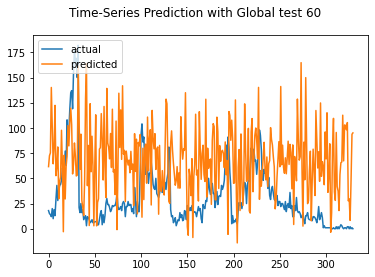

Test MAE: 52.652
Test RMSE: 61.615
Test sMAPE: 105.840
Test R Squared: -2.928
{'mae': 52.6518807367845, 'rmse': 61.61463610485043, 'smape': 105.84033863350919, 'r2': -2.9283464065480453}


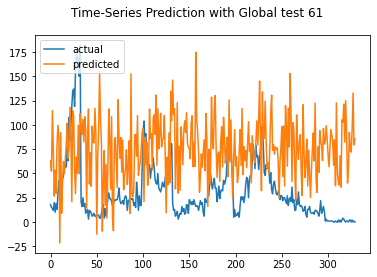

Test MAE: 48.398
Test RMSE: 58.691
Test sMAPE: 104.904
Test R Squared: -2.564
{'mae': 48.39773259090655, 'rmse': 58.69121011050652, 'smape': 104.90390523779965, 'r2': -2.564413908759754}


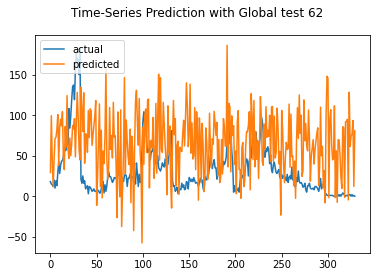

Test MAE: 51.368
Test RMSE: 59.892
Test sMAPE: 107.297
Test R Squared: -2.712
{'mae': 51.36762853824731, 'rmse': 59.89240778441119, 'smape': 107.29690422138594, 'r2': -2.7118083755634697}


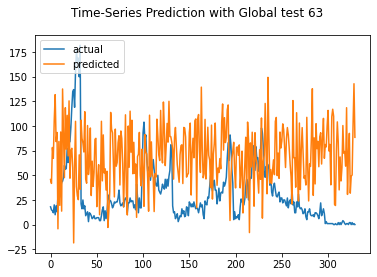

Test MAE: 47.607
Test RMSE: 57.781
Test sMAPE: 104.409
Test R Squared: -2.455
{'mae': 47.60654838374167, 'rmse': 57.78084671464054, 'smape': 104.40942946931595, 'r2': -2.454695744217178}


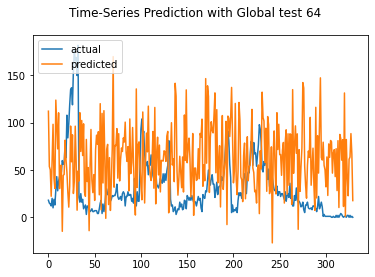

Test MAE: 37.363
Test RMSE: 47.636
Test sMAPE: 101.693
Test R Squared: -1.348
{'mae': 37.363311816435875, 'rmse': 47.63595056908125, 'smape': 101.69309273357895, 'r2': -1.3480734261237117}


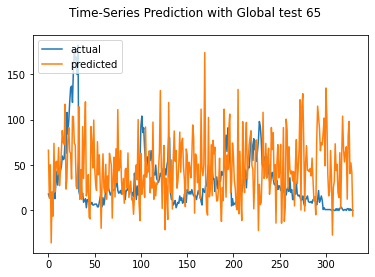

Test MAE: 35.699
Test RMSE: 44.948
Test sMAPE: 96.552
Test R Squared: -1.091
{'mae': 35.6991423108361, 'rmse': 44.94824172722442, 'smape': 96.55150341370788, 'r2': -1.0905830131216727}


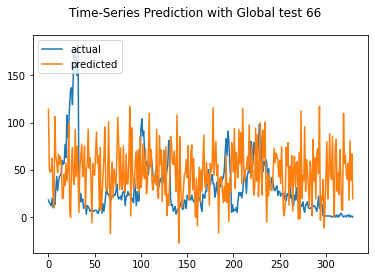

Test MAE: 59.528
Test RMSE: 68.189
Test sMAPE: 110.188
Test R Squared: -3.811
{'mae': 59.52837749394504, 'rmse': 68.18886563482693, 'smape': 110.18790944135672, 'r2': -3.811371963138586}


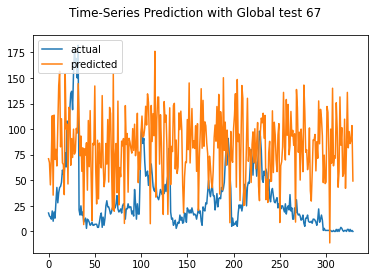

Test MAE: 52.542
Test RMSE: 62.570
Test sMAPE: 108.323
Test R Squared: -3.051
{'mae': 52.5421039026795, 'rmse': 62.56975722516473, 'smape': 108.32337411116352, 'r2': -3.051081136189289}


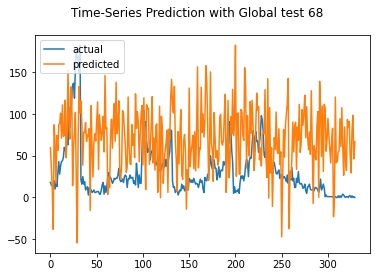

Test MAE: 55.398
Test RMSE: 63.694
Test sMAPE: 106.717
Test R Squared: -3.198
{'mae': 55.39813914443507, 'rmse': 63.69368997315823, 'smape': 106.71748965876186, 'r2': -3.197926408579116}


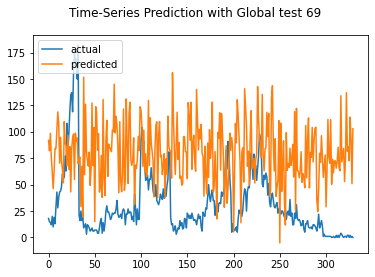

Test MAE: 50.692
Test RMSE: 59.488
Test sMAPE: 104.369
Test R Squared: -2.662
{'mae': 50.69159231908394, 'rmse': 59.48767659854744, 'smape': 104.36944974740179, 'r2': -2.661811766194424}


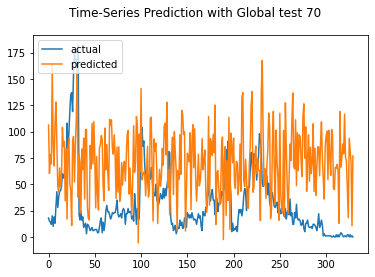

Test MAE: 75.542
Test RMSE: 83.441
Test sMAPE: 120.442
Test R Squared: -6.204
{'mae': 75.5422680932464, 'rmse': 83.44066308993719, 'smape': 120.44190768423955, 'r2': -6.204394650411241}


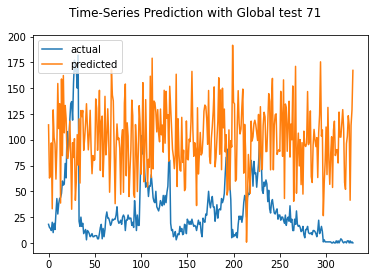

Test MAE: 60.897
Test RMSE: 67.899
Test sMAPE: 113.161
Test R Squared: -3.771
{'mae': 60.89662197719921, 'rmse': 67.8987480575999, 'smape': 113.16118865643008, 'r2': -3.7705179576951915}


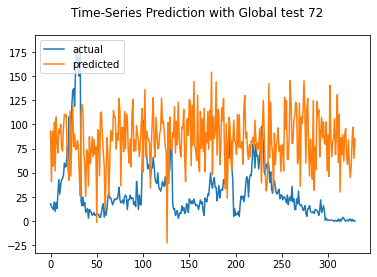

Test MAE: 37.346
Test RMSE: 47.147
Test sMAPE: 104.404
Test R Squared: -1.300
{'mae': 37.34587012276505, 'rmse': 47.14651147859669, 'smape': 104.40404822428584, 'r2': -1.30007039738828}


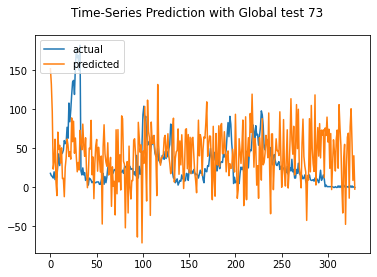

Test MAE: 61.334
Test RMSE: 71.022
Test sMAPE: 110.425
Test R Squared: -4.220
{'mae': 61.33373103430777, 'rmse': 71.022265771233, 'smape': 110.42490160619758, 'r2': -4.219525792293441}


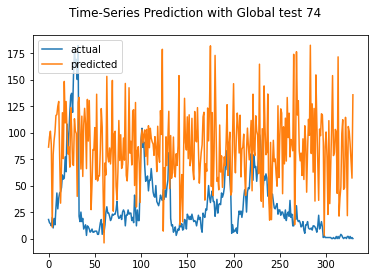

Test MAE: 49.501
Test RMSE: 60.319
Test sMAPE: 109.714
Test R Squared: -2.765
{'mae': 49.500883839708386, 'rmse': 60.31901563631436, 'smape': 109.71368207436419, 'r2': -2.7648744040575655}


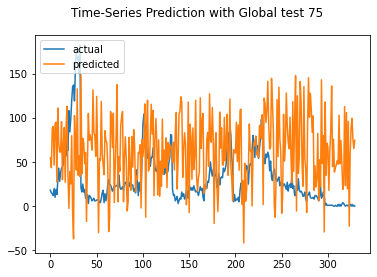

Test MAE: 50.135
Test RMSE: 58.246
Test sMAPE: 102.910
Test R Squared: -2.510
{'mae': 50.13485633315462, 'rmse': 58.24561276797075, 'smape': 102.90999578499724, 'r2': -2.510495646866502}


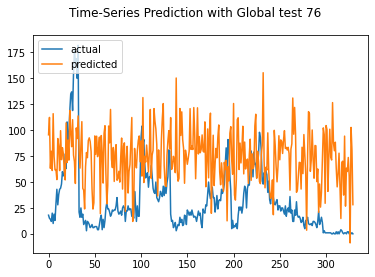

Test MAE: 73.870
Test RMSE: 82.930
Test sMAPE: 118.801
Test R Squared: -6.117
{'mae': 73.86991983471495, 'rmse': 82.93021724451737, 'smape': 118.80146774236279, 'r2': -6.116518911530566}


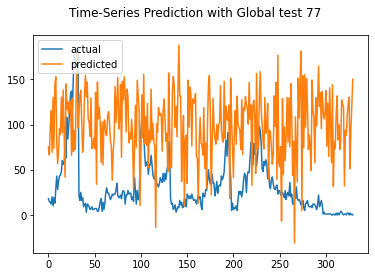

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 47.528
Test RMSE: 59.555
Test sMAPE: 128.709
Test R Squared: -2.670
{'mae': 47.527584259347485, 'rmse': 59.55534243761643, 'smape': 128.70948400503528, 'r2': -2.67014695430648}


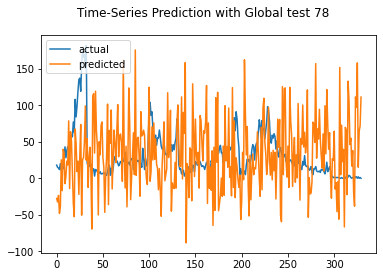

Test MAE: 35.911
Test RMSE: 45.029
Test sMAPE: 97.673
Test R Squared: -1.098
{'mae': 35.911404727625126, 'rmse': 45.02903515681573, 'smape': 97.67266776715009, 'r2': -1.0981053172980864}


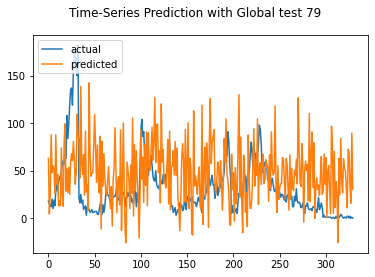

Test MAE: 40.488
Test RMSE: 49.589
Test sMAPE: 99.545
Test R Squared: -1.545
{'mae': 40.48791351264173, 'rmse': 49.588610093693504, 'smape': 99.54468879720487, 'r2': -1.5445200254428144}


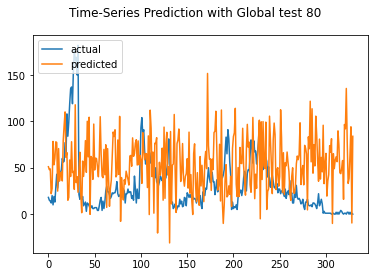

Test MAE: 59.314
Test RMSE: 67.601
Test sMAPE: 110.648
Test R Squared: -3.729
{'mae': 59.31359344323476, 'rmse': 67.60079645621938, 'smape': 110.64818537328293, 'r2': -3.728742082125839}


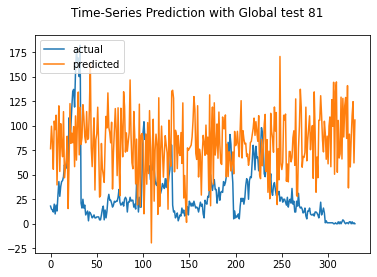

Test MAE: 51.765
Test RMSE: 60.199
Test sMAPE: 104.103
Test R Squared: -2.750
{'mae': 51.76491359797391, 'rmse': 60.19929615613843, 'smape': 104.10292366946717, 'r2': -2.749944402136183}


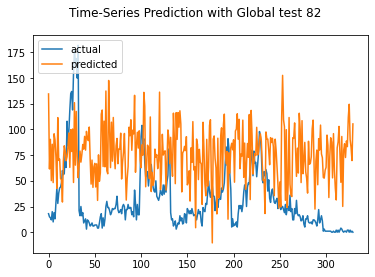

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 47.140
Test RMSE: 59.625
Test sMAPE: 113.208
Test R Squared: -2.679
{'mae': 47.13970585402214, 'rmse': 59.62453162183317, 'smape': 113.20847035561641, 'r2': -2.6786795886308923}


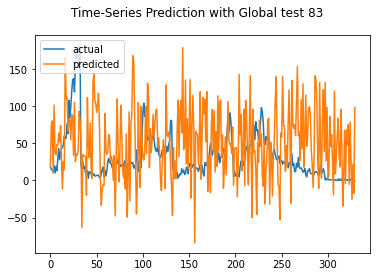

Test MAE: 37.152
Test RMSE: 47.783
Test sMAPE: 106.191
Test R Squared: -1.363
{'mae': 37.151987073276985, 'rmse': 47.7829856047118, 'smape': 106.19101649309587, 'r2': -1.3625911122637038}


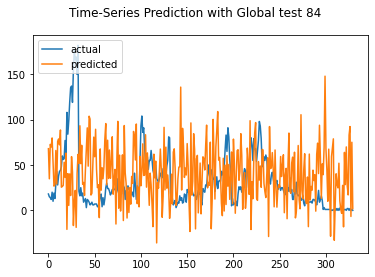

Test MAE: 46.098
Test RMSE: 55.866
Test sMAPE: 105.362
Test R Squared: -2.229
{'mae': 46.098458988738784, 'rmse': 55.86573231544927, 'smape': 105.36165921020357, 'r2': -2.229482933628278}


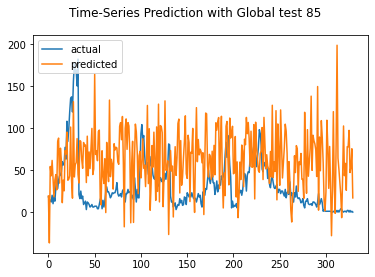

Test MAE: 52.776
Test RMSE: 62.438
Test sMAPE: 107.444
Test R Squared: -3.034
{'mae': 52.776342169443765, 'rmse': 62.43849007851356, 'smape': 107.44430444184003, 'r2': -3.0341011742318793}


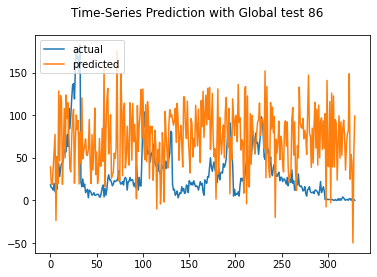

Test MAE: 46.987
Test RMSE: 55.397
Test sMAPE: 101.514
Test R Squared: -2.175
{'mae': 46.98689645095305, 'rmse': 55.396632659668654, 'smape': 101.51429986608572, 'r2': -2.175475268405486}


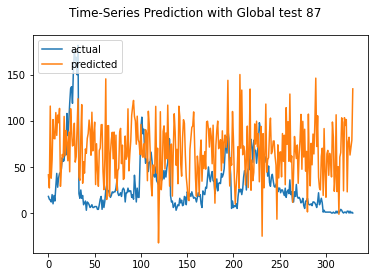

Test MAE: 40.859
Test RMSE: 49.180
Test sMAPE: 98.377
Test R Squared: -1.503
{'mae': 40.858834846091995, 'rmse': 49.17977256621025, 'smape': 98.3765927822728, 'r2': -1.5027359596144132}


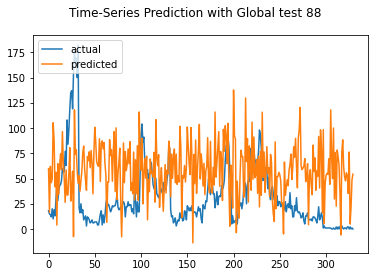

Test MAE: 49.415
Test RMSE: 58.852
Test sMAPE: 104.499
Test R Squared: -2.584
{'mae': 49.41457426475756, 'rmse': 58.85173915402622, 'smape': 104.49851494392864, 'r2': -2.58393896093519}


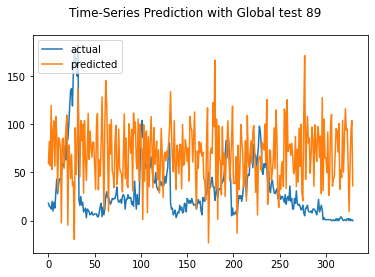

Test MAE: 70.988
Test RMSE: 79.715
Test sMAPE: 116.278
Test R Squared: -5.575
{'mae': 70.98825894702564, 'rmse': 79.71546600998835, 'smape': 116.27838290774866, 'r2': -5.575475746880095}


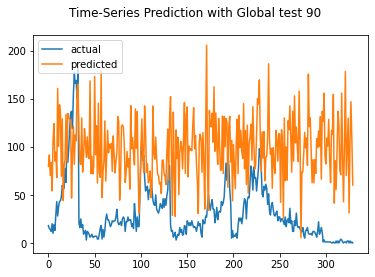

Test MAE: 54.210
Test RMSE: 62.360
Test sMAPE: 107.152
Test R Squared: -3.024
{'mae': 54.21009425538959, 'rmse': 62.36039253579554, 'smape': 107.15239920586835, 'r2': -3.024015845284568}


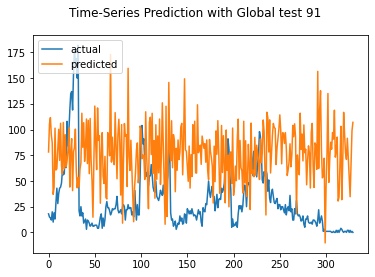

Test MAE: 50.073
Test RMSE: 58.149
Test sMAPE: 106.601
Test R Squared: -2.499
{'mae': 50.0728430946668, 'rmse': 58.14868138353445, 'smape': 106.60103773525447, 'r2': -2.4988211517377814}


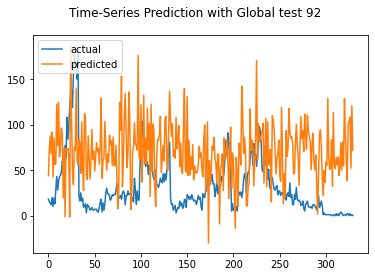

Test MAE: 66.790
Test RMSE: 75.555
Test sMAPE: 114.334
Test R Squared: -4.907
{'mae': 66.78960908868096, 'rmse': 75.55522796200886, 'smape': 114.33425352536966, 'r2': -4.907055375606041}


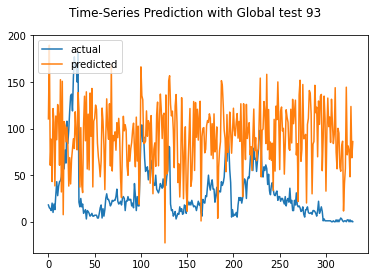

Test MAE: 56.493
Test RMSE: 66.114
Test sMAPE: 107.845
Test R Squared: -3.523
{'mae': 56.492684368111874, 'rmse': 66.11385226281226, 'smape': 107.84523910611789, 'r2': -3.523003539706692}


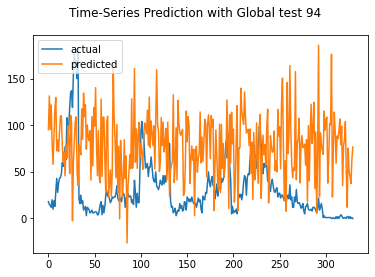

Test MAE: 56.104
Test RMSE: 64.560
Test sMAPE: 109.623
Test R Squared: -3.313
{'mae': 56.10366346727718, 'rmse': 64.5600530662104, 'smape': 109.62309851590788, 'r2': -3.3129036788085733}


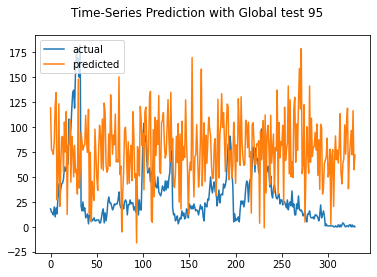

Test MAE: 76.862
Test RMSE: 84.729
Test sMAPE: 120.438
Test R Squared: -6.429
{'mae': 76.86210908022794, 'rmse': 84.72948551278856, 'smape': 120.438316006955, 'r2': -6.428671265530213}


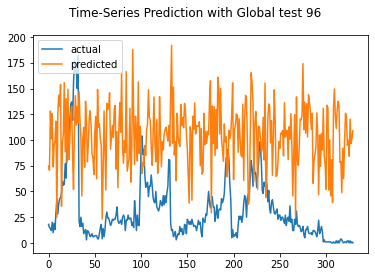

Test MAE: 62.565
Test RMSE: 71.057
Test sMAPE: 112.878
Test R Squared: -4.225
{'mae': 62.56522821946577, 'rmse': 71.05701185898386, 'smape': 112.87846082524894, 'r2': -4.224634118871484}


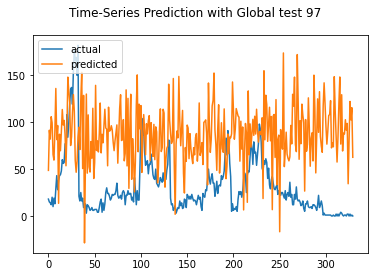

Test MAE: 40.144
Test RMSE: 50.192
Test sMAPE: 103.168
Test R Squared: -1.607
{'mae': 40.144057867743754, 'rmse': 50.19158357870041, 'smape': 103.16820247948618, 'r2': -1.6067765050615672}


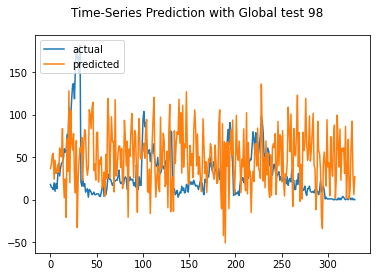

Test MAE: 46.106
Test RMSE: 54.855
Test sMAPE: 104.360
Test R Squared: -2.114
{'mae': 46.10603076472427, 'rmse': 54.85512505922954, 'smape': 104.36039461898432, 'r2': -2.1136975193324505}


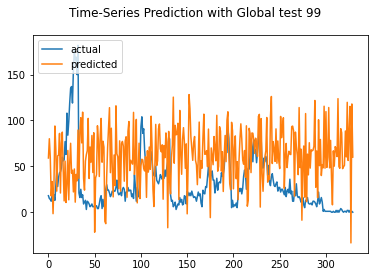

rmse : average=59.018, std=9.672
mae : average=49.751, std=9.903
smape : average=106.199, std=5.968
r2 : average=-2.701, std=1.263


([59.01840371696405, 9.672464990699956],
 [49.751013451633135, 9.902834206126292],
 [106.19912848159201, 5.967550875324092],
 [-2.7010758339691963, 1.263048918507994])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')